In [12]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import sys
import os
sys.path.append(os.path.abspath('../'))

from model_search.model_service import calculate_ratios, calculated_features

## 1. Cel projektu

Do projektu wykorzystano zbiór danych finansowych spółek amerykańskich, zawierający dane liczbowe z pięciu kolejnych lat działalności każdej firmy. Celem klasyfikacji jest przewidzenie, czy dana spółka zbankrutuje w ciągu roku od ostatniego okresu sprawozdawczego. Dane zostały pozyskane z [githuba](https://github.com/grepoz/multimodal-bankruptcy-dataset), a oryginalnie pochodzą z portalu [Gurufocus](https://www.gurufocus.com).

## 2. Baza danych


### 2.1 Struktura danych

Zbiór danych zawiera łącznie **7214 spółek**, z czego dane dla **2748 firm (około 38%) zostały syntetycznie wygenerowane** na potrzeby zbalansowania klas. Dane są już wstępnie podzielone na podzbiory: train, val oraz test.

Każda firma reprezentowana jest przez **5 wierszy** – każdy odpowiada jednemu rokowi danych finansowych. Każdy wiersz zawiera zarówno dane (cechy finansowe), jak i zmienną zależną (ang. dependent variable) "label", która określa to, czy firma zbankrutowała w ciągu roku od zakończenia okresu sprawozdawczego (True) lub nie (False).

In [15]:
financial_dataset = pd.read_csv('../data/numerical_dataset_oversampled.csv')
print(financial_dataset.shape)
financial_dataset.head(5)

(36070, 22)


,cik,ticker,label,subset,Fiscal Period,Cost of Goods Sold,Depreciation Depletion Amortization,EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,737874,LI,False,train,Aug 2002,479.0,281.0,1028.0,1310.0,4004.0,...,-1223.0,-10.0,4483.0,3853.0,948.0,695.0,50.0,2562.0,3829.0,570.0
1,737874,LI,False,train,Aug 2003,479.0,281.0,1028.0,1310.0,4004.0,...,-1223.0,-10.0,4483.0,3853.0,948.0,695.0,50.0,2562.0,3829.0,570.0
2,737874,LI,False,train,Aug 2004,483.0,284.0,224.0,507.0,4149.0,...,62.0,52.0,4631.0,3905.0,1032.0,687.0,51.0,2529.0,3928.0,588.0
3,737874,LI,False,train,Aug 2005,579.0,249.0,63.0,312.0,2447.0,...,212.0,249.0,3027.0,2909.0,606.0,448.0,33.0,1309.0,2282.0,203.0
4,737874,LI,False,train,Aug 2006,582.0,216.0,261.0,477.0,2550.0,...,125.0,315.0,3132.0,3039.0,741.0,531.0,41.0,1831.0,2299.0,211.0


### 2.2 Znaczenie kolumn
Zbiór danych zawiera następujące typy kolumn:

- **Metadane**:
  - `cik` – identyfikator spółki (unikalny numer firmy w bazie SEC- Central Index Key),
  - `ticker` – skrót giełdowy spółki,
  - `Fiscal Period` – okres sprawozdawczy (np. `Dec 2019`),
  - `subset` – informacja o przynależności do zbioru `train`, `test` lub `val`.

- **Cechy numeryczne** (17 kolumn): zawierają wartości liczbowe dotyczące kondycji finansowej, takie jak np.:
  - `Revenue`, `Net Income`, `Total Assets`, `EBITDA`, `Cost of Goods Sold`, `Total Liabilities`, `Operating Cash Flow`, `Depreciation & Amortization`, itp.

- **Kolumna docelowa (`label`)** – wartość logiczna (`True`/`False`) oznaczająca, czy spółka zbankrutowała.

### 2.3 Klasyfikacja

Celem klasyfikacji jest przypisanie każdej spółce odpowiedniej etykiety (`label`) na podstawie danych z ostatnich pięciu lat jej działalności. Jest to problem binarnej klasyfikacji – firma albo zbankrutuje (`True`), albo nie (`False`).

### 2.4 Statystyki ogólne

Dla wstępnej analizy dokonano:
- obliczenia liczby spółek i rozmiaru każdego z podzbiorów (`train`, `val`, `test`),

In [31]:
financial_data_grouped = financial_dataset.groupby('cik').agg({'ticker': 'first', 'label': 'first', 'subset': 'first'})
print(f"Number of companies in the dataset: {financial_data_grouped.shape[0]}")
print(financial_data_grouped['subset'].value_counts(normalize=True))

Number of companies in the dataset: 7214
subset
train    0.798447
test     0.151234
val      0.050319
Name: proportion, dtype: float64


- wyświetlenie rozkładu klas

In [32]:
financial_data_grouped['label'].value_counts(normalize=True)

label
False    0.608816
True     0.391184
Name: proportion, dtype: float64

- sprawdzenia rozmiaru i rozkładu danych syntetycznych,

In [33]:
financial_data_grouped_original_dataset = financial_data_grouped[financial_data_grouped['ticker'].isnull()]
financial_data_grouped_original_dataset['label'].value_counts()

label
True    2748
Name: count, dtype: int64

W kolumnach `Fiscal Period` oraz `ticker` widzimy brakujące wartości dla danych syntetycznych. Są one efektem nadpróbkowania zbioru danych. Nie będziemy ich usuwać, ponieważ pozostałe istotne dane są poprawne.

In [37]:
financial_dataset.isnull().sum().sort_values(ascending=False)

Fiscal Period                          13740
ticker                                 13740
cik                                        0
Net Income                                 0
Total Operating Expense                    0
Total Liabilities                          0
Total Inventories                          0
Total Current Liabilities                  0
Total Current Assets                       0
Total Assets                               0
Revenue                                    0
Retained Earnings                          0
Market Cap                                 0
Long-Term Debt                             0
Gross Profit                               0
EBITDA                                     0
EBIT                                       0
Depreciation Depletion Amortization        0
Cost of Goods Sold                         0
subset                                     0
label                                      0
Total Receivables                          0
dtype: int

Sprawdzenie ilości zer w danych numerycznych z podziałem na poszczególne kolumny. Zbiór danych zawiera zera, ponieważ brakujące dane w Gurufocus zostały zastąpione zerami, a same dane mogą naturalnie zawierać zera (np. dla cechy „Zysk netto” spółka mogła nie osiągnąć zysku w danym okresie).

Procent zer w zbiorze danych jest niski.

In [35]:
zeros_values_count_per_col = financial_dataset.iloc[:, 5:][financial_dataset == 0].count()
zeros_values_count_per_col.sort_values(ascending=False)

Depreciation Depletion Amortization    519
Net Income                             432
EBIT                                   341
EBITDA                                 285
Long-Term Debt                         269
Retained Earnings                      203
Total Receivables                      128
Cost of Goods Sold                      96
Total Inventories                       80
Gross Profit                            46
Revenue                                 35
Total Current Liabilities               16
Total Current Assets                    15
Total Operating Expense                 14
Total Liabilities                       11
Total Assets                            10
Market Cap                               3
dtype: int64

In [36]:
all_values_count = financial_dataset.iloc[:, 5:].count().sum()
print(f'Percentage of zeros in the dataset: {zeros_values_count_per_col.sum() / all_values_count * 100:.2f}%')

Percentage of zeros in the dataset: 0.41%


- weryfikacji jakości danych poprzez ręczne porównanie z informacjami dostępnymi na stronach takich jak [AlphaSpread](https://www.alphaspread.com), [Yahoo Finance](https://finance.yahoo.com) czy [Investing.com](https://www.investing.com).

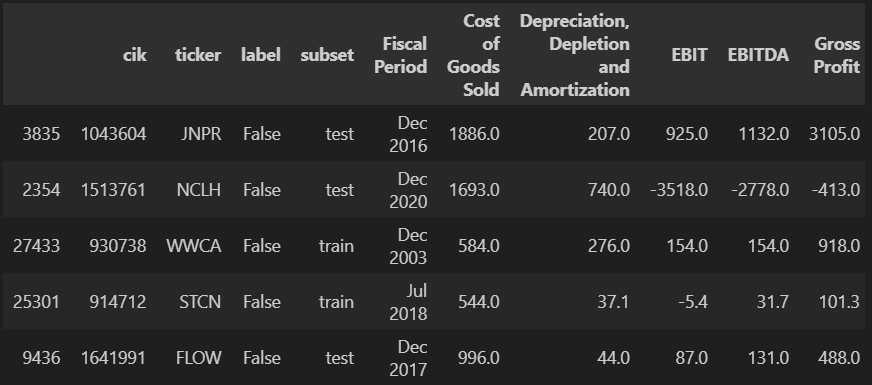

JNRP (grudzień 2016):
- wartość „amortyzacja i umorzenia” zgadza się: https://www.alphaspread.com/security/nyse/jnpr/financials/cash-flow-statement
- wartość „zysk netto” zgadza się: https://www.alphaspread.com/security/nyse/jnpr/financials/income-statement/net-income-common

NCLH (grudzień 2020):
- wartość „amortyzacja i umorzenia” zgadza się: https://www.alphaspread.com/security/nasdaq/nclh/financials/cash-flow-statement
- wartość „zysk netto” zgadza się: https://www.alphaspread.com/security/nyse/nclh/financials/income-statement/net-income-common

WWCA (grudzień 2003):
- spółka nie została znaleziona na stronach https://www.alphaspread.com oraz https://finance.yahoo.com – prawdopodobnie zbyt stara spółka. Sprawdzenie wartości „zysk netto”, „przychody” i „aktywa ogółem” poprzez stronę amerykańskiej komisji SEC również nie powiodło się: https://www.sec.gov/Archives/edgar/data/930738/000089102003002613/v93911e10vq.htm
- spółka została przejęta w sierpniu 2005: https://en.wikipedia.org/wiki/Western_Wireless_Corporation

STCN (lipiec 2018):
- wartość „amortyzacja i umorzenia” zgadza się: https://www.alphaspread.com/security/nasdaq/stcn/financials/cash-flow-statement
- wartość „zysk netto” prawie się zgadza (35,4): https://www.alphaspread.com/security/nasdaq/stcn/financials/income-statement/net-income-common

FLOW (grudzień 2017):
- wartość „zysk netto” oraz „aktywa ogółem” zgadzają się: https://www.investing.com/equities/spx-flow-inc-financial-summary

Wnioski:

Dane są poprawne dla 4 z 5 spółek. Zakładamy więc, że dane dla pozostałych firm również są poprawne. Serwis Gurufocus pobiera dane z Morningstar, który jest uznawany za wiarygodne źródło.

### 2.5 Wnioski z analizy

Zbiór danych jest dobrze przygotowany do uczenia modeli klasyfikacyjnych. Posiada zbalansowane klasy, logiczną strukturę i reprezentuje rzeczywiste dane finansowe, które można zweryfikować z niezależnych źródeł. Dzięki swojej strukturze (5 lat danych per spółka) oraz etykiecie binarnej, idealnie nadaje się do trenowania modeli predykcyjnych, które uczą się na podstawie trendów w danych finansowych.